# Sentiment Analysis and Hate-Speech Detection on Tweets

In [25]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from helper_functions import *

## Sentiment Data EDA

In [26]:
df=pd.read_csv('data/Sentiment140.csv', encoding='latin-1', header=None, index_col=False)
df = df[[0, 5]].rename(columns={0: "target", 5: "text"})
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [27]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [28]:
# output the dataframe structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   text    1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


<AxesSubplot:>

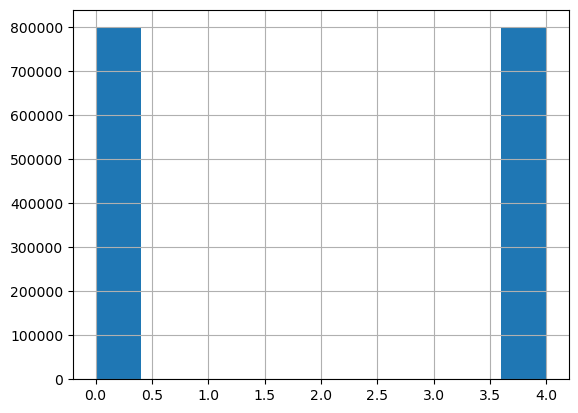

In [29]:
#Convert target to categorical
df['target'] = pd.Categorical(df.target)
df['target'].unique()
df['target'].hist()

In this dataset, target values describe the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive). However, there are only negative and positive tags (0 and 4) so let's change those values to 0 = negative, 1 = positive

<AxesSubplot:>

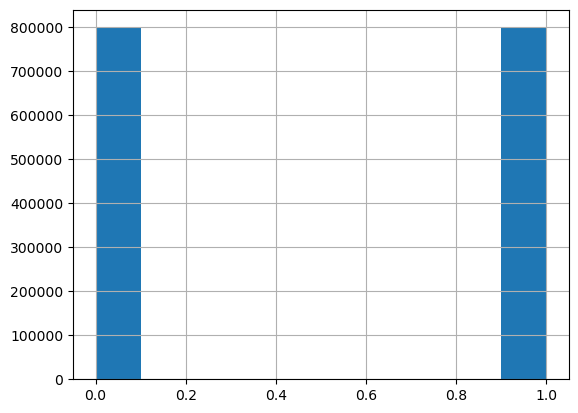

In [30]:
df['target'] = df['target'].replace(4,1) #Replace 4 (positive) by 1. Negative (0) remain the same
df['target'].hist()

<AxesSubplot:>

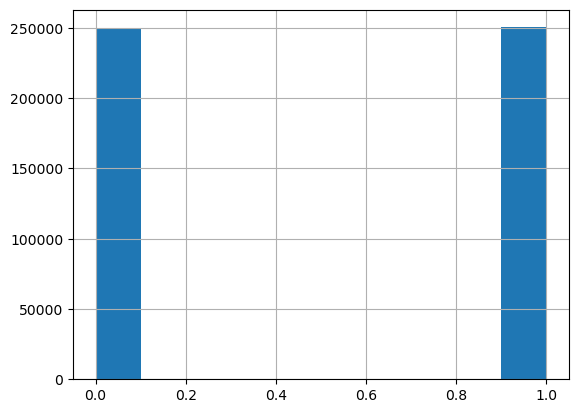

In [31]:
#For testing purposes, get a sample of the data
df=df.sample(500000)
df['target'].hist()

## Hate Speech Data EDA

In [32]:
df_hate=pd.read_csv('data/HateSpeech_tweets.csv', encoding='latin-1', usecols  = ["class", "tweet"])
df_hate = df_hate.rename(columns={"class": "target", "tweet": "text"})
df_hate.head()

,target,text
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [33]:
df_hate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  24783 non-null  int64 
 1   text    24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


In [34]:
df_hate.isnull().sum()

target    0
text      0
dtype: int64

<AxesSubplot:>

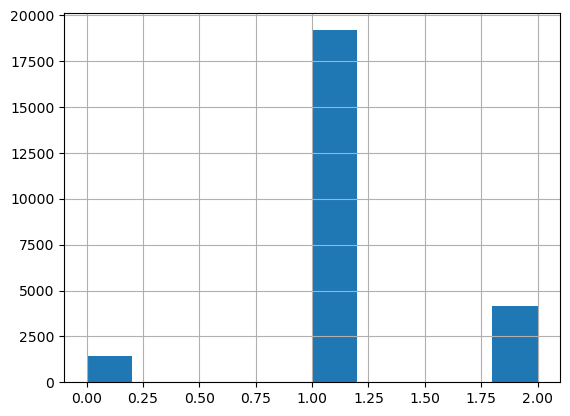

In [35]:
#Convert target to categorical
df_hate['target'] = pd.Categorical(df_hate.target)
df_hate['target'].unique()
df_hate['target'].hist()

UPDATE THIS IF WE ARE FINALLY KEEPING NON_OFFENSIVE TWEETS
In this dataset, target values describe the type of the tweet (0 - hate speech, 1 - offensive language, 2 - neither). However, for the desired task we are only interested in retrieving the hate speech and offensive language and identify a Negative Sentiment. Thus, we will remove the non-offensive text rows (tagged as 2-neither) and combine hate speech (0) and offensive language (1) into the same category 0, which is the value we used when traning the model to tag a Negative sentiment.

<AxesSubplot:>

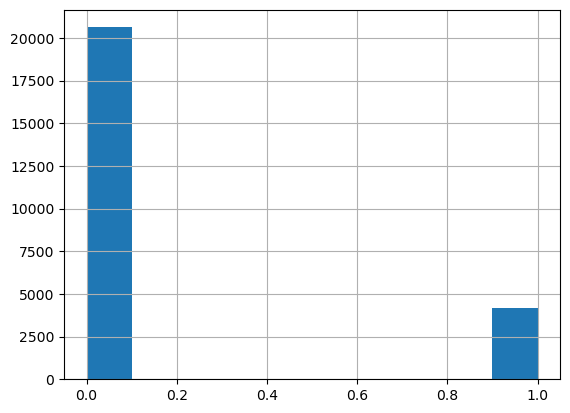

In [36]:
df_hate['target'] = df_hate['target'].replace(1,0) #Replace 1 (positive) by 0 to group hate speech and offensive language teweet into the same category
df_hate['target'] = df_hate['target'].replace(2,1) #Replace 1 (positive) by 0 to group hate speech and offensive language teweet into the same category
#df_hate = df_hate[df_hate['target'] == 0] #Keep only the rows with hate/offensive tweets
df_hate['target'].hist()

In [51]:
# Split text from labels
X_hate=df_hate['text']
y_hate=df_hate['target']

## Train/ Test Split: Sentiment Data

In [52]:
# Split in training set and, testing set and separate labels from data
X=df['text']
y=df['target']
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state = 0)

## Naive Bayes Model

### Preprocessing Sentiment Data

In [53]:
estimators=[('cleaner', FunctionTransformer(data_cleaning)), #TODO Add stop words param
            ('vectorizer', TfidfVectorizer(max_features=100000, ngram_range=(1, 2)))] #TODO Check these values
preprocessing_pipeline=Pipeline(estimators)

In [54]:
#Preprocess the training set
X_train_transformed=preprocessing_pipeline.fit_transform(X_train)
#At 22min fails

In [55]:
#Preprocess test set
X_test_transformed=preprocessing_pipeline.transform(X_test)

### Train Sentiment Model

In [56]:
# Create a Naive Bayes model and fit the training data
naive_bayes_model=MultinomialNB()
naive_bayes_model.fit(X_train_transformed, y_train)

MultinomialNB()

### Evaluate Sentiment Model

In [57]:
# Evaluate model
print(f'Test Score: {naive_bayes_model.score(X_test_transformed, y_test)}')
print(f'Train Score: {naive_bayes_model.score(X_train_transformed, y_train)}')

Test Score: 0.795656
Train Score: 0.828432


### Hate Speech Detection with Naive Bayes Model

In [58]:
#Preprocess data
X_transformed=preprocessing_pipeline.transform(X_hate)

In [59]:
#Evaluate model on hate speech
print(f'Score: {naive_bayes_model.score(X_transformed, y_hate)}')

Score: 0.5181374329177258


## LSTM 

In [15]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras import layers

2022-12-03 21:25:41.620461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Preprocessing Sentiment Data

Todo
- Refactor the code so any shared cleaning, train/test/split code is handled once for all models. Otherwise, create a separate notebook for each model (the processing, training, and evaluation processes)
- Check on the validation_data. Do we need train, val, and test to avoid overfitting?
- We're overfitting. Add dropout layers, etc. to reduce overfitting
- Use GLoVE embeddings to speed up training process
- Check all the parameters we're passing
- Evaluate the model and apply it to the hatespeech data

In [60]:
# Split in training set and, testing set and separate labels from data
X=df['text']
y=df['target']
X = data_cleaning(X)
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state = 0)

In [45]:
tokenizer=Tokenizer() # change to the non-deprecated tf.keras.layers.TextVectorization 
tokenizer.fit_on_texts(X_train)
vocab_size=len(tokenizer.word_index)+1
print(f'Vocab Size: {vocab_size}')
X_train=pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=40)
X_test=pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=40)
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

Vocab Size: 227268


### Train Sentiment Model

In [49]:
model=Sequential()
model.add(layers.Embedding(input_dim=vocab_size,\
                           output_dim=100,\
                           input_length=40)) 
model.add(layers.Bidirectional(layers.LSTM(128))) 
model.add(layers.Dense(2,activation='softmax'))
model.compile(optimizer='adam',\
              loss='categorical_crossentropy',\
              metrics=['accuracy'])

model.fit(X_train,\
          y_train,\
          batch_size=256,\
          epochs=5,\
          validation_data=(X_test,y_test))


Epoch 1/5
1465/1465 [==============================] - 304s 206ms/step - loss: 0.4500 - accuracy: 0.7879 - val_loss: 0.4152 - val_accuracy: 0.8095
Epoch 2/5
1465/1465 [==============================] - 295s 201ms/step - loss: 0.3167 - accuracy: 0.8639 - val_loss: 0.4576 - val_accuracy: 0.7963
Epoch 3/5
1465/1465 [==============================] - 289s 198ms/step - loss: 0.2148 - accuracy: 0.9118 - val_loss: 0.5031 - val_accuracy: 0.7892
Epoch 4/5
1465/1465 [==============================] - 287s 196ms/step - loss: 0.1583 - accuracy: 0.9350 - val_loss: 0.6250 - val_accuracy: 0.7862
Epoch 5/5
1465/1465 [==============================] - 287s 196ms/step - loss: 0.1229 - accuracy: 0.9495 - val_loss: 0.7529 - val_accuracy: 0.7776


In [50]:
model.save('./LSTM_model_v0_3Dec22')

INFO:tensorflow:Assets written to: ./LSTM_model_v0_3Dec22/assets


INFO:tensorflow:Assets written to: ./LSTM_model_v0_3Dec22/assets


### Evaluate Sentiment Model

### Hate Speech Detection with Naive Bayes Model

## VADER on Hate Speech Data

In [22]:
import pandas as pd
from sklearn.metrics import accuracy_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from matplotlib import pyplot as plt

According to the academic paper on VADER, the Valence score is measured on a scale from -4 to +4, where -4 stands for the most 'Negative' sentiment and +4 for the most 'Positive' sentiment. Let's set the following ranges for defining the polarity of the text:

- From -4 to 0: Negative --> 0
- From 0 to 4: Positive --> 1

In [23]:
analyzer = SentimentIntensityAnalyzer()

In [24]:
df_vader = df_hate #Make copy
df_vader['vader']=df_vader.apply(lambda x: analyzer.polarity_scores(x['text'])['compound'], axis=1)
df_vader.head()

,target,text,vader
0,1,!!! RT @mayasolovely: As a woman you shouldn't...,0.4563
1,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,-0.6876
2,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,-0.9550
3,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,0.5673
4,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,0.6331


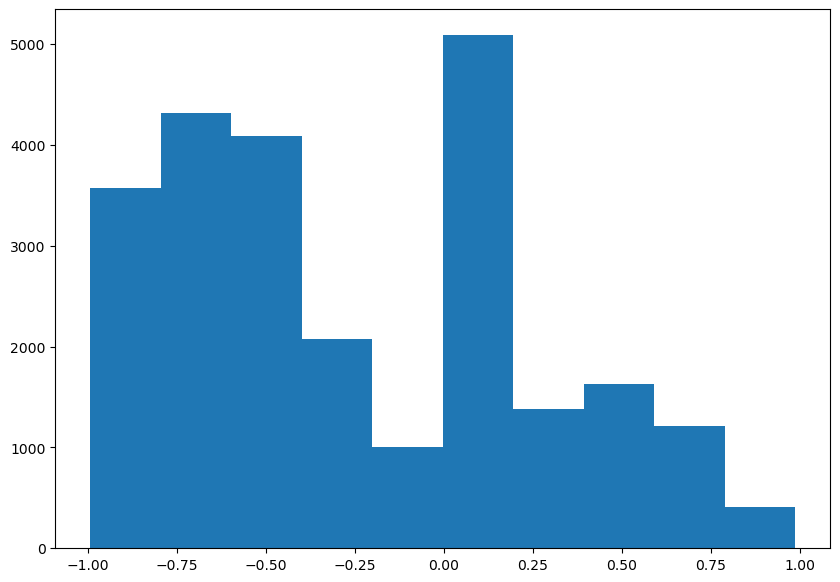

In [25]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(df_vader['vader'])
plt.show()

In [26]:
#Translate polarity into 0-Negative or 1-Other
df_vader['predicted_target']=df_vader.apply(lambda x: 0 if x['vader'] <= 0 else 1, axis=1)
df_vader.head()

,target,text,vader,predicted_target
0,1,!!! RT @mayasolovely: As a woman you shouldn't...,0.4563,1
1,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,-0.6876,0
2,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,-0.9550,0
3,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,0.5673,1
4,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,0.6331,1


In [27]:
# Evaluate results
print(f'Accuracy: {accuracy_score(df_vader.dropna()["target"].values, df_vader.dropna()["predicted_target"].values)}')

Accuracy: 0.7401041036194166
